# House Price Prediction

## 목차

### 1. 프로젝트 개요
### 2. Preprocessing
### 3. EDA & Feature selection
### 4. 모델링
### 5. 예측 및 제출

## 1. 프로젝트 개요
1. 내용: 주택의 정보(위치, 시설 상태 등)를 통해 가격 예측
2. 데이터 set: row 2919 x column 81 - 80개 변수, target은 Price
3. 평가 기준:  RMSE(Root-Mean-Squared-Error)
4. 수단: Ordinary Least Squares regression (OLS)
5. 최종 성적: 0.14826, 5112명 중 2509위

In [1]:
# 경고창 보이지 않기
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

# 그래프 설정
plt.rcParams["figure.figsize"] = (13,4)
%matplotlib inline

In [3]:
# data 가져오기

df_train = pd.read_csv('./input_data/train.csv')
df_test = pd.read_csv('./input_data/test.csv')
df = pd.concat([df_train.drop('SalePrice', 1), df_test])

## 2. Preprocessing

### 2-1. target data
- 예측해야하는 결과 값인 주택 가격의 분포를 살펴봄

#### 결과
- 오른쪽 꼬리가 긴 모양을 보임.
- log를 취해 정규분포에 가깝게 데이터를 변환해 줌.

In [4]:
y = df_train['SalePrice']
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

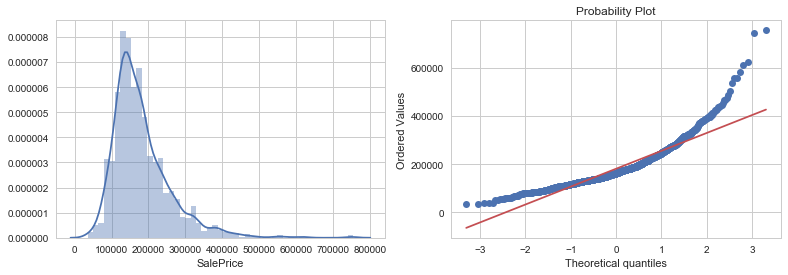

In [5]:
# 시각화
plt.rcParams["figure.figsize"] = (13,4)

plt.subplot(121)
sns.distplot(y)
## QQ plot
plt.subplot(122)
sp.stats.probplot(y, plot=plt)
plt.show()

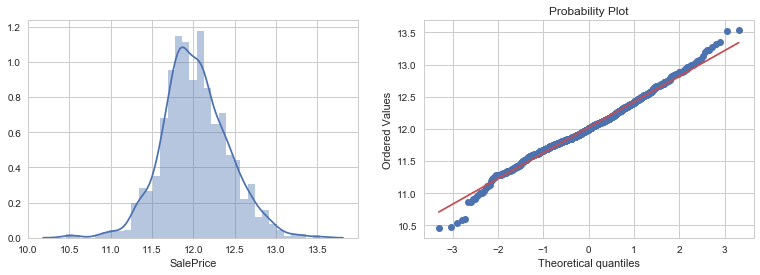

In [6]:
# log 변환
y2 = np.log(y)

# 시각화
plt.rcParams["figure.figsize"] = (13,4)

plt.subplot(121)
sns.distplot(y2)
## QQ plot
plt.subplot(122)
sp.stats.probplot(y2, plot=plt)
plt.show()

In [7]:
# df_train의 SalePrice를 log 취해줌.

df_train['SalePrice'] = df_train['SalePrice'].apply(lambda x : np.log(x))

### 2-2. feature data 확인

- info 함수
- https://goo.gl/19Qkf1 문서 참고
- 실수값과 카테고리값이 섞여 있음
    - 카테고리 값 처리 필요
- missing data 처리 필요

In [8]:
# 변수 info 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

### 2-3. Null 값 처리

#### missing data는 train과 test를 함께  처리

- 카테고리 값 중에서 order가 있는 변수는 숫자로 바꿔서 회귀분석 진행
    - 그래프 상으로 봤을 때 등급이 올라가면 대체로 SalePrice가 올라감을 확인
- null 값은 해당 항목에 대한 '시설'이 없는 것임으로 점수를 0으로 매겨줌.

In [9]:
# null 있는 column 체크
def nan_check(df_raw):
    null_check = df_raw.isnull().sum()
    null_count = pd.DataFrame({'column' : null_check.index, 'NaN' : null_check.values})
    # None 값이 있는 column만 가져옴.
    null_count = null_count.query('NaN > 0')
    return(null_count)

# null 없는 column 체크
def nan_check2(df_raw):
    null_check = df_raw.isnull().sum()
    null_count = pd.DataFrame({'column' : null_check.index, 'NaN' : null_check.values})
    # None 값이 없는 column만 가져옴.
    null_count = null_count.query('NaN == 0')
    return(null_count)

train, test 데이터에 대한 null 값 체크

In [10]:
nan_check(df)

,NaN,column
2,4,MSZoning
3,486,LotFrontage
6,2721,Alley
9,2,Utilities
23,1,Exterior1st
24,1,Exterior2nd
25,24,MasVnrType
26,23,MasVnrArea
30,81,BsmtQual
31,82,BsmtCond


In [11]:
# 순서가 있는 카테고리 데이터에 숫자 부여

tonum = {"ExterQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "ExterCond": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "BsmtQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "BsmtCond": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "HeatingQC": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "KitchenQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "FireplaceQu": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "GarageQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "GarageCond": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "PoolQC": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "BsmtFinType1" : {'GLQ' : 6, 'ALQ' : 5, 'BLQ': 4,'Rec' : 3,'LwQ' : 2, 'Unf' : 1, np.nan : 0},
         "BsmtFinType2" : {'GLQ' : 6, 'ALQ' : 5, 'BLQ': 4,'Rec' : 3,'LwQ' : 2, 'Unf' : 1, np.nan : 0},
         "BsmtExposure" : {'Gd' : 4, 'Av': 3,'Mn' : 2,'No' : 1, np.nan : 0},
         
        }

df= df.replace(tonum)

- nan 값이 '시설 없음'인 변수들에 대해서 'N' 이라는 클래스를 부여해 줌 : 카테고리 값
- nan 값이 '시설 없음'인 변수들에 대해서 0으로 대체 : 실수 값

In [12]:
fill_na_ls = ['GarageType', 'MiscFeature', 'Fence', 'GarageFinish', 'Alley', 'MasVnrType']

for name in fill_na_ls:
    df[name] = df[name].fillna('N')

fill_zero_ls = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'MasVnrArea']

for name in fill_zero_ls:
    df[name] = df[name].fillna(0)
    
fill_mode_ls = ['Electrical', 'Utilities', 'Functional', 'MSZoning', 'SaleType', 'LotFrontage', 'Exterior1st', 'Exterior2nd']
for name in fill_mode_ls:
    df[name] = df[name].fillna(df[name].mode()[0])

In [13]:
# 비슷한 항목인 넓이를 TotSF라는 항목으로 합해줌.
df['TotSF'] = df['1stFlrSF'] + df['TotalBsmtSF'] + df['2ndFlrSF']

- null 값 없음 체크!

In [14]:
nan_check(df)

,NaN,column


### 2-4. train, test 데이터 분리
- df : train data
- df_test : test data

In [15]:
df_test = df.iloc[1460:]
df = df.iloc[:1460]
df['SalePrice'] = df_train['SalePrice']

In [16]:
# 변수 살펴보기

# 카테고리 변수
cat_ls = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'GarageCars', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'GarageYrBlt', 'BsmtFullBath', 'BedroomAbvGr', 'MoSold', 'BsmtHalfBath', 'YrSold', 'KitchenAbvGr']
df_cat = df[cat_ls]
df_cat['SalePrice'] = df['SalePrice']

# 실수 변수
num_ls = list(set(df.columns) - set(cat_ls))
df_num = df[num_ls]
df_num['SalePrice'] = df['SalePrice']

# 실수가 아닌 카테고리 변수
str_cat_ls = ['Alley', 'PavedDrive', 'Functional', 'MSZoning', 'LandSlope', 'GarageType', 'Exterior1st', 'Neighborhood', 'SaleType', 'LandContour', 'Electrical', 'MasVnrType', 'LotShape', 'Fence', 'HouseStyle', 'Street', 'GarageFinish', 'BldgType', 'CentralAir', 'Condition1', 'Foundation', 'RoofStyle', 'MiscFeature', 'LotConfig', 'RoofMatl', 'Condition2', 'Heating', 'Utilities', 'Exterior2nd', 'SaleCondition']

## 3. EDA & Feature Selection

### 3-1. numerical data
- 독립변수와 종속변수 간 상관계수 확인
- 상관계수가 높은 데이터의 plot 확인

#### 선택한 데이터
- OverallQual, TotSF, GrLivArea, GarageCars, ExterQual, KitchenQual, GarageArea, BsmtQual, YearBuilt, YearRemodAdd, OverallCond

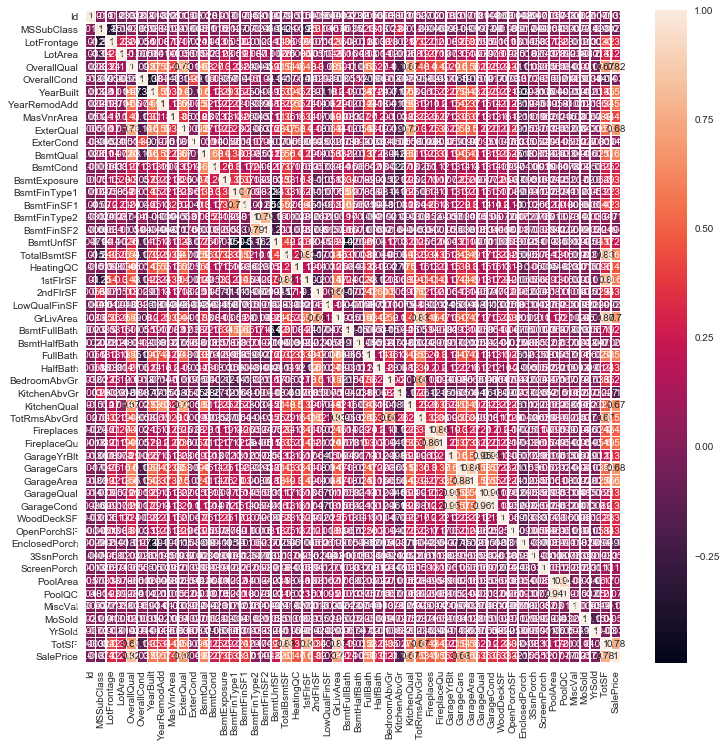

In [17]:
heat= df.corr()
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(heat.iloc[:, :], annot=True, linewidths=.5, ax=ax)

<  SalePrice  >
1.0


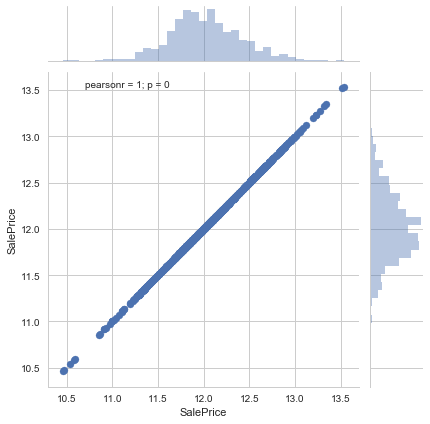

<  OverallQual  >
0.8171844179216822


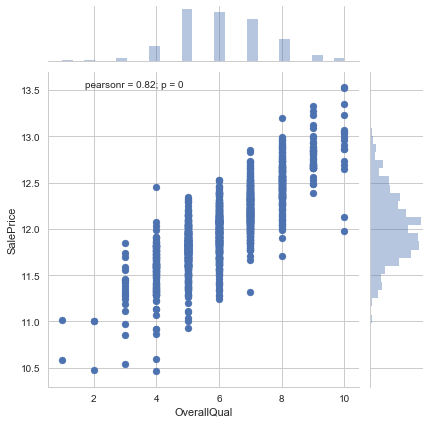

<  TotSF  >
0.777296214853449


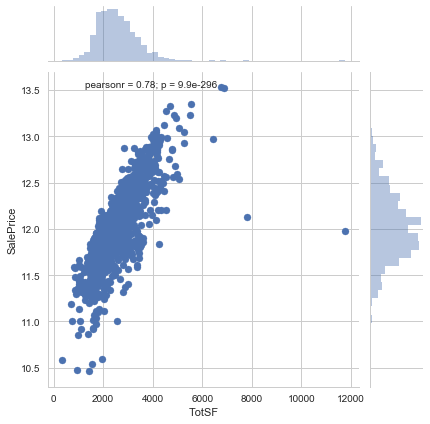

<  GrLivArea  >
0.7009266525441293


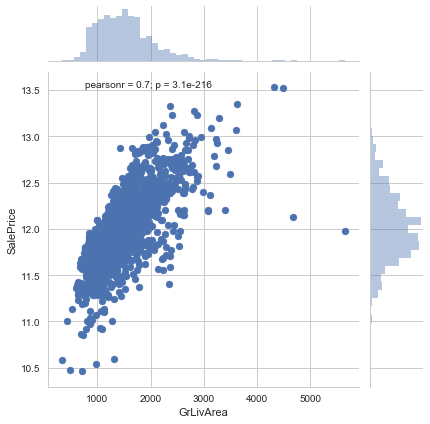

In [18]:
corr = heat['SalePrice'].sort_values(ascending=False)

for col_name in corr.index[:4]:
    print("< ",col_name," >")
    print(corr[col_name])
    sns.jointplot(x=col_name, y="SalePrice", data=df)
    plt.show()

### 3-2. categorical data

- one-way ANOVA를 통해 p-value, $R^2$, $R^2_{adj}$ 계산
- 상관관계가 높은 변수 선택

#### 선택한 데이터
- Neighborhood, MasVnrType, SaleType, MSZoning

In [19]:
# one-way ANOVA 시행 예시
import scipy.stats as scipystats
scipystats.f_oneway(df.loc[df["KitchenAbvGr"] == 0].SalePrice,
                    df.loc[df["KitchenAbvGr"] == 3].SalePrice,
                    df.loc[df["KitchenAbvGr"] == 1].SalePrice,
                    df.loc[df["KitchenAbvGr"] == 2].SalePrice)

F_onewayResult(statistic=11.534894703481985, pvalue=1.7875405872957032e-07)

In [21]:
# 결과는 f_p_value.csv에 따로 저장
f_p_value = pd.read_csv('./additional_file/f_p_value.csv', index_col=0)

In [22]:
anova_test = pd.DataFrame(columns=['col_name', 'f-test', 'rs', 'rs_a'])
for x1 in str_cat_ls:
    model = sm.OLS.from_formula("SalePrice ~ C({}) + 0".format(x1), data=df)
    
    result = model.fit()
    rs = result.rsquared
    rs_a = result.rsquared_adj
    f_test = f_p_value['pvalue'][x1]
    
    anova_test = anova_test.append({'col_name': x1, 'f-test':f_test, 'rs':rs, 'rs_a':rs_a}, ignore_index=True)
    
anova_test.sort_values('f-test', ascending=True)

,col_name,f-test,rs,rs_a
7,Neighborhood,1.497729e-224,0.570808,0.563630
16,GarageFinish,1.199117e-93,0.381034,0.379758
20,Foundation,5.791895e-91,0.303651,0.301257
5,GarageType,1.247154e-66,0.334639,0.331892
11,MasVnrType,4.793331e-65,0.194503,0.192289
29,SaleCondition,7.988268e-44,0.129020,0.126025
6,Exterior1st,2.586089e-43,0.181531,0.173601
28,Exterior2nd,4.842186e-43,0.171463,0.162856
8,SaleType,5.039767e-42,0.120115,0.115264
3,MSZoning,8.817634e-35,0.175839,0.173573


In [23]:
def show_viobox(df,col_name):
    print(col_name)
        
    # 각 항목에 대한 빈도 출력 / df2 dataframe 따로 생성
    df2 = pd.DataFrame(df[col_name])
    counts = df2.groupby([col_name]).size().reset_index(name='Counts')
    print(counts)
        
    plt.subplot(121)
    sns.violinplot(x=col_name, y='SalePrice', data=df)
    plt.subplot(122)
    sns.boxplot(x=col_name, y='SalePrice', data=df)
    plt.show()

MSSubClass
    MSSubClass  Counts
0           20     536
1           30      69
2           40       4
3           45      12
4           50     144
5           60     299
6           70      60
7           75      16
8           80      58
9           85      20
10          90      52
11         120      87
12         160      63
13         180      10
14         190      30


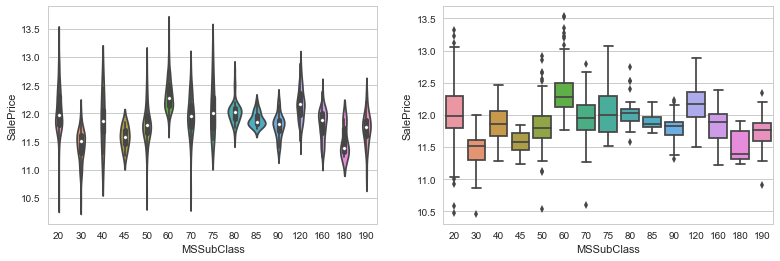

MSZoning
  MSZoning  Counts
0  C (all)      10
1       FV      65
2       RH      16
3       RL    1151
4       RM     218


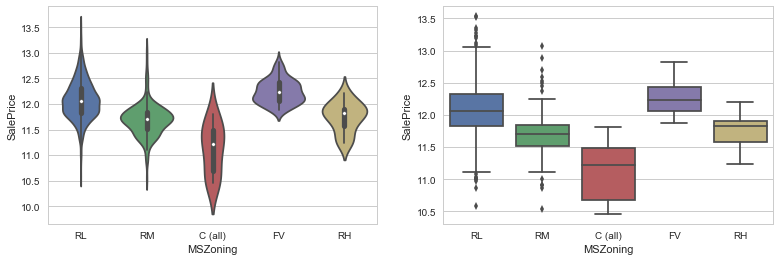

Street
  Street  Counts
0   Grvl       6
1   Pave    1454


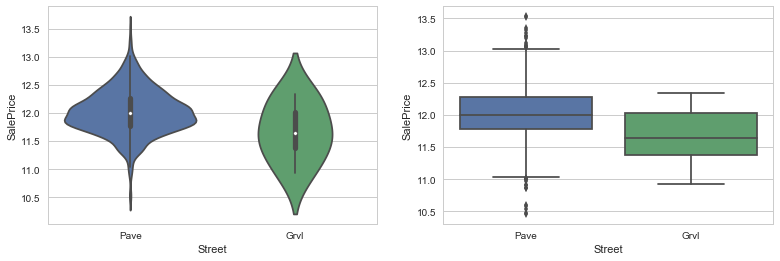

Alley
  Alley  Counts
0  Grvl      50
1     N    1369
2  Pave      41


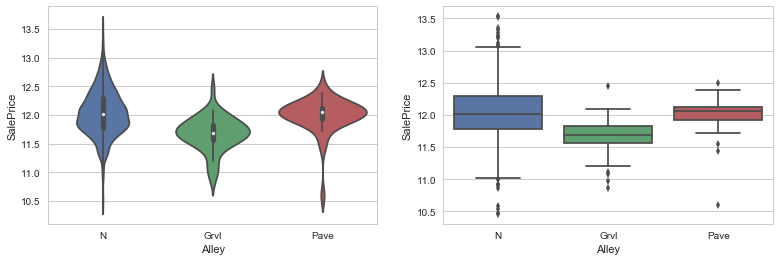

In [24]:
# plot을 통해 데이터 살펴봄.

plt.rcParams["figure.figsize"] = (13,4)
for col in cat_ls[:4]:
    show_viobox(df, col)

# 4. 모델링

### 4-1. OLS Regression 모델 - 카테고리 값
- 위에서 고른 feature 중 카테고리 값만으로 OLS 모델링
- F-테스트를 통한 확률이 지나치게 높아 유의미하지 않다고 생각되는 변수 다시한번 제거

In [112]:
df_all = df.copy()
model_num = sm.OLS.from_formula("SalePrice ~ scale(OverallQual) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(ExterQual) + scale(KitchenQual) + scale(GarageArea) + scale(BsmtQual) + scale(YearBuilt) + scale(YearRemodAdd) + scale(OverallCond)", data = df_all)

result_num = model_num.fit()

In [113]:
sm.stats.anova_lm(result_num, typ=2).sort_values('PR(>F)')

,sum_sq,df,F,PR(>F)
scale(OverallQual),4.073561,1.0,159.413562,9.563978e-35
scale(OverallCond),4.037749,1.0,158.012096,1.805537e-34
scale(YearBuilt),3.659031,1.0,143.191440,1.551681e-31
scale(TotSF),2.097960,1.0,82.100963,4.079722e-19
scale(GrLivArea),1.540141,1.0,60.271438,1.552461e-14
scale(GarageCars),0.959421,1.0,37.545684,1.148790e-09
scale(KitchenQual),0.400774,1.0,15.683767,7.850095e-05
scale(BsmtQual),0.284217,1.0,11.122458,8.744584e-04
scale(ExterQual),0.020620,1.0,0.806952,3.691724e-01
scale(GarageArea),0.014101,1.0,0.551823,4.576942e-01


### 4-2. 카테고리 변수 간 다중공선성 확인
 - 상관계수가 높은 GrLivArea, TotSF 중 TotSF 제거
 - 다중공선성 확인을 위해 VIF 확인

In [116]:
cor_ls = ['OverallQual', 'TotSF', 'GrLivArea', 'GarageCars', 'KitchenQual', 'BsmtQual', 'YearBuilt']

df_cor = df[cor_ls]
df_cor.corr()

,OverallQual,TotSF,GrLivArea,GarageCars,KitchenQual,BsmtQual,YearBuilt
OverallQual,1.000000,0.668155,0.593007,0.600671,0.673331,0.629379,0.572323
TotSF,0.668155,1.000000,0.874373,0.536413,0.502738,0.514299,0.347133
GrLivArea,0.593007,0.874373,1.000000,0.467247,0.420563,0.327956,0.199010
GarageCars,0.600671,0.536413,0.467247,1.000000,0.509810,0.449194,0.537850
KitchenQual,0.673331,0.502738,0.420563,0.509810,1.000000,0.510938,0.530165
BsmtQual,0.629379,0.514299,0.327956,0.449194,0.510938,1.000000,0.602797
YearBuilt,0.572323,0.347133,0.199010,0.537850,0.530165,0.602797,1.000000


In [117]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_cor.values, i) for i in range(df_cor.shape[1])]
vif["features"] = df_vif.columns
vif

,VIF Factor,features
0,62.674108,OverallQual
1,62.750051,TotSF
2,44.654376,GrLivArea
3,11.137243,GarageCars
4,56.549802,KitchenQual
5,33.371702,BsmtQual
6,36.694763,YearBuilt


### 4-3. OLS Regression 모델 확정
- 위 과정에서 일부 feature 데이터 제거 후 최종 모델 확정
- 모델링 결과
    - R-square: 0.866
    - Adj. R-square: 0.863
    - Condition No.: 96.1

In [136]:
df_all = df.copy()
model_all = sm.OLS.from_formula("SalePrice ~ C(Neighborhood) + C(MasVnrType) + C(SaleType) + C(MSZoning) + scale(OverallQual) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearBuilt) + scale(OverallCond)", data = df_all)

result_all = model_all.fit()

In [137]:
sm.stats.anova_lm(result_all, typ=2).sort_values('PR(>F)')

,sum_sq,df,F,PR(>F)
scale(GrLivArea),12.515051,1.0,601.144353,6.859299e-111
scale(OverallCond),3.193523,1.0,153.396776,1.610690e-33
scale(OverallQual),3.018038,1.0,144.967589,7.471820e-32
C(Neighborhood),4.262204,24.0,8.530395,2.742246e-28
scale(GarageCars),2.645645,1.0,127.080136,2.767290e-28
scale(BsmtQual),1.321724,1.0,63.487326,3.298626e-15
C(MSZoning),1.469266,4.0,17.643570,3.844522e-14
scale(YearBuilt),0.871362,1.0,41.854775,1.352003e-10
scale(KitchenQual),0.421232,1.0,20.233328,7.416735e-06
C(SaleType),0.323432,8.0,1.941952,5.039756e-02


In [139]:
df_all = df.copy()
model_all = sm.OLS.from_formula("SalePrice ~ C(Neighborhood) + C(MasVnrType) + scale(OverallQual) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearBuilt) + scale(OverallCond)", data = df_all)

result_all = model_all.fit()
print(result_all.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     262.9
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:08:09   Log-Likelihood:                 735.90
No. Observations:                1460   AIC:                            -1400.
Df Residuals:                    1424   BIC:                            -1209.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### 4-4. 다항회귀
- 다항식을 이용하면 더 나은 성능을 보이는 변수가 있는지 살펴봄.
- 교차검증을 통해 성능이 좋은 모델 두가지를 선정
    - A 모델
        - R-square: 0.886
        - Adj. R-square: 0.883
        - Condition No.: 268
    - B 모델
        - R-square: 0.885
        - Adj. R-square: 0.882
        - Condition No.: 106

$$ y = OQ + OC + GA + KQ + GC + BQ + YB + Category $$

In [12]:
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(10)
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))

0.8611639414474418


$\Diamond$ $$ y = OQ + OC + GA + GA^2 + KQ + GC + BQ + YB + Category $$

In [13]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418

0.8740162661327586


$\Diamond$ $$ y = OQ + OC + GA + GA^2 + GA^3 + KQ + GC + BQ + YB + Category $$

In [14]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418

0.8768850176780472


$\Diamond$ $$ y = OQ + OC + GA + KQ + KQ^2 + KQ^3 + GC + BQ + YB + Category $$

In [16]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(KitchenQual) + scale(I(KitchenQual**2)) + scale(I(KitchenQual**3)) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418

0.8613856681692802


$\Diamond$  $$ y = OQ + OC + GA + KQ + GC + BQ + BQ^2 + BQ^3 + YB + Category $$

In [17]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(I(BsmtQual**2)) + scale(I(BsmtQual**3)) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418

0.8614886615374939


$\Diamond$ $$ y = OQ + OC + GA + KQ + GC + BQ + BQ^2 + BQ^3 + BQ^4 + YB + Category $$

In [18]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(I(BsmtQual**2)) + scale(I(BsmtQual**3)) + scale(I(BsmtQual**4)) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418

0.8613280215623472


$\Diamond$ $$ y = OQ + OC + GA + GA^2 + GA^3 + KQ +KQ^2 +KQ^3 + GC + BQ + YB + Category $$

In [19]:
y, X = dmatrices("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(I(KitchenQual**2)) + scale(I(KitchenQual**3))  + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", df, return_type = 'dataframe' )
model = LinearRegression().fit(X, y)
cvs = list(cross_val_score(model, X, y, scoring="r2", cv=cv))
print(np.mean(cvs))
# origin : 8611639414474418
# GAorigin : 0.8768850176780474
# KQorigin : 0.86138566816928


0.8785461600496355


#### A 모델

$$ y = OQ + OC + GA + GA^2 + GA^3 + KQ +KQ^2 +KQ^3 + GC + BQ + YB + Category $$

In [23]:
model_a = sm.OLS.from_formula("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(I(KitchenQual**2)) + scale(I(KitchenQual**3)) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", data=df)
result_a = model_a.fit()
print(result_a.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     284.0
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:19:40   Log-Likelihood:                 856.26
No. Observations:                1460   AIC:                            -1633.
Df Residuals:                    1420   BIC:                            -1421.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

#### B 모델

$$ y = OQ + OC + GA + GA^2 + GA^3 + KQ  + GC + BQ + YB + Category $$

In [25]:
model_b = sm.OLS.from_formula("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", data=df)
result_b = model_b.fit()

print(result_b.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     294.9
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:24:14   Log-Likelihood:                 845.50
No. Observations:                1460   AIC:                            -1615.
Df Residuals:                    1422   BIC:                            -1414.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### 4-5. 레버리지를 통한 아웃라이어 제거
- 레버리지를 확인해 아웃라이어 제거
- 아웃라이어 제거 후 모델링 다시 진행
    - A 모델
        - R-square: 0.925
        - Adj. R-square: 0.923
        - Condition No.: 280
    - B 모델
        - R-square: 0.920
        - Adj. R-square: 0.918
        - Condition No.: 184

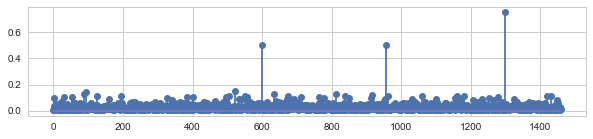

In [26]:
influence = result_a.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

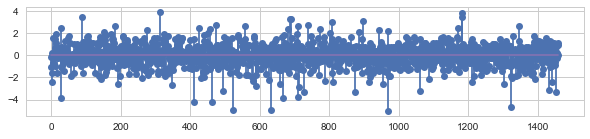

In [28]:
# 표준화 잔차 계산
plt.figure(figsize=(10, 2))
plt.stem(result_a.resid_pearson)
plt.show()

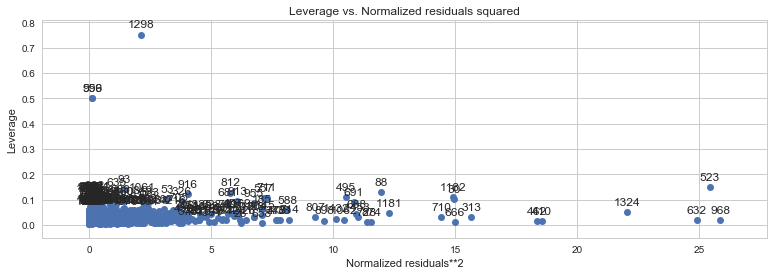

In [29]:
plt.figure(figsize=(50, 50))
sm.graphics.plot_leverage_resid2(result_a)
plt.show()

#### A 모델 - 아웃라이어 제거 후

In [51]:
influence = result_a.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (1460 - 1 - 38)
idx = np.where(cooks_d2 > fox_cr)[0]
idx = list(set(idx) - set([599, 956]))
df_fin1 = df.copy()
df_fin1 = df_fin1.drop(df_fin1.index[idx])

In [52]:
model_a2 = sm.OLS.from_formula("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(I(KitchenQual**2)) + scale(I(KitchenQual**3)) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", data=df_fin1)
result_a2 = model_a2.fit()
print(result_a2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     410.8
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:42:58   Log-Likelihood:                 1205.3
No. Observations:                1332   AIC:                            -2331.
Df Residuals:                    1292   BIC:                            -2123.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

#### B 모델 - 아웃라이어 제거 후

In [46]:
influence = result_b.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 3 / (1460 - 1 - 37)
idx = np.where(cooks_d2 > fox_cr)[0]
idx = list(set(idx) - set([599, 956]))
df_fin2 = df.copy()
df_fin2 = df_fin2.drop(df_fin2.index[idx])

In [47]:
model_b2 = sm.OLS.from_formula("SalePrice ~ scale(OverallQual) + scale(OverallCond) + scale(GrLivArea) + scale(I(GrLivArea**2)) + scale(I(GrLivArea**3)) + scale(KitchenQual) + scale(GarageCars) + scale(BsmtQual) + scale(YearBuilt) + C(Neighborhood) + C(MSZoning)", data=df_fin2)
result_b2 = model_b2.fit()

print(result_b2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     413.7
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:37:17   Log-Likelihood:                 1156.3
No. Observations:                1363   AIC:                            -2237.
Df Residuals:                    1325   BIC:                            -2038.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### 4-6. 잔차 정규성 확인

#### A 모델의 잔차 정규성 확인

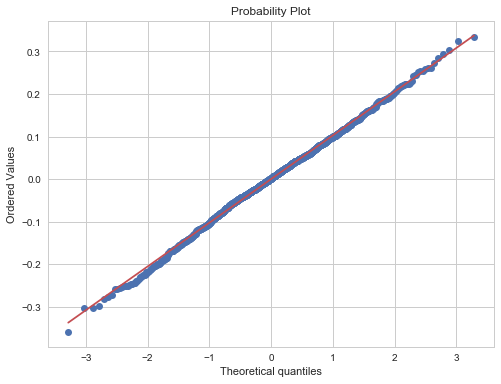

Chi^2       :  3.226
P-value     :  0.199


In [49]:
plt.figure(figsize=(8, 6))
sp.stats.probplot(result_a2.resid, plot=plt)
plt.show()
#잔차 정규성 P-value
test = sms.omni_normtest(result_a2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

#### B 모델의 잔차 정규성

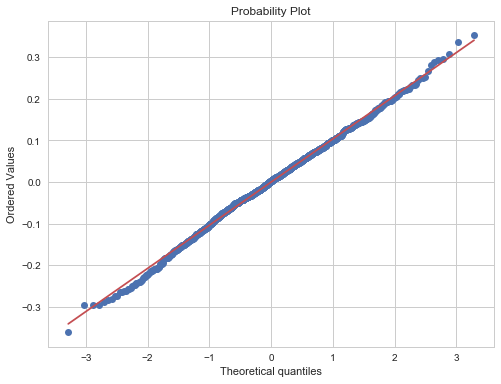

Chi^2       :  4.376
P-value     :  0.112


In [50]:
plt.figure(figsize=(8, 6))
sp.stats.probplot(result_b2.resid, plot=plt)
plt.show()
#잔차 정규성 P-value
test = sms.omni_normtest(result_b2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

## 5. 예측 및 제출

### A 모델
- Kaggle Score 
    - RMSE = 0.14909

$$ y = OQ + OC + GA + GA^2 + GA^3 + KQ +KQ^2 +KQ^3 + GC + BQ + YB + Category $$

### B 모델
- Kaggle Score 
    - RMSE = 0.14826

$$ y = OQ + OC + GA + GA^2 + GA^3 + KQ  + GC + BQ + YB + Category $$